# pRealGARCH(P,p,q₁,q₂)

    GARCH equation

        loghₜ = ω(mod(t-1,m)+1) + ∑(r=1,..,p) βᵣ loghₜ₋ᵣ +  ∑(i=1,...,q₁) τ₁ᵢzₜ₋ᵢ  + ∑(j=1,...,q₂) τ₂ⱼ(zₜ₋ⱼ²-1) +  + γ′uₜ  for m = 1,...,P  where P is the number of periodicity parameters. 

    Measurement Equation

        log xₜ = ξ + log hₜ + δ(zₜ) + uₜ 

        where δ(z)=δ₁z + δ₂(z²-1)
 
rₜ = √hₜ zₜ,  zₜ ~ N(0,1)



**Reference:**
P.R. Hansen, Zhuo Huang, H.H. Shek, 2012. Realized GARCH: A joint model for returns and realized measures of volatility. Journal of Applied Econometrics 
P.R. Hansen, Zhuo Huang, 2015. Exponential GARCH modeling with realized measures of volatility. Journal of Business & Economic Statistics

In [1]:
#import package
using CSV, DataFrames
using Optim
using Plots
include("../src/ARCHModels.jl")
using .ARCHModels

In [9]:
# load data
tickers = ["SPY","KO","AAPL","TSLA","JNJ","CVX"]
ticker = tickers[1] # Choose ticker 
filename = ticker*"_RMs.csv"#
readpath = dirname(pwd())*"\\src\\data\\"*filename
df = DataFrame(CSV.File(readpath,header = 1))

,Column1,RV_15s,RV_2min,RV_5min,RV_10min,RV_15min,DR
,Date,Float64,Float64,Float64,Float64,Float64,Float64
1,2015-01-02,5.3e-5,6.6e-5,5.98e-5,5.92e-5,6.4e-5,0.0131125
2,2015-01-05,9.54e-5,0.000108023,8.86e-5,0.000101305,0.000108972,0.0148874
3,2015-01-06,0.000109731,9.35e-5,0.000119639,0.000137793,0.000144754,0.0192498
4,2015-01-07,0.000152944,0.000123204,0.000117869,0.00011723,0.000134762,0.009118
5,2015-01-08,9.02e-5,0.000103325,0.000109735,0.000119771,0.000150087,0.0105816
6,2015-01-09,6.86e-5,6.99e-5,6.41e-5,5.73e-5,9.37e-5,0.0141248
7,2015-01-12,6.93e-5,7.6e-5,6.95e-5,7.46e-5,7.07e-5,0.0130869
8,2015-01-13,0.000148913,0.000180678,0.000257363,0.000256669,0.000301285,0.0244347
9,2015-01-14,0.000254339,0.00023792,0.00019501,0.000210565,0.000183436,0.0126606


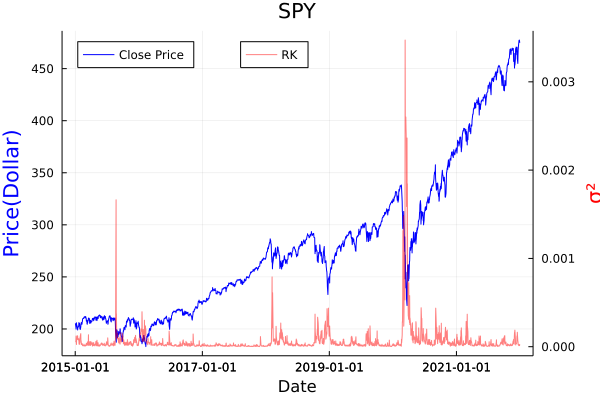

In [53]:
# Price and Volatility plot
myplot = plot(df[:,1],df.close,title=ticker,color=:blue,legend=:topleft,label="Close Price",ylabel="Price(Dollar)",xlabel="Date",rightmargin = 1.5Plots.cm,yguidefont = font(:blue))
plt = twinx()
plot!(plt,df[:,1],df.RK,alpha=0.5,color=:red,legend=:top,label="RK",ylabel="σ²",yguidefont = font(:red))

In [55]:
#split insample / out-of-sample
N₁ = 1000
# Close to Close return and Realized Kernel
c2c_r = diff(log.(df.close))
rm = df[2:end,"RK"]

rt = c2c_r
xt = rm
rt_N₁ = c2c_r[1:N₁]
xt_N₁ = rm[1:N₁]


1000-element Vector{Float64}:
 5.68e-5
 0.000120978
 4.96e-5
 2.48e-5
 7.51e-5
 8.76e-5
 0.000124697
 9.53e-5
 0.000120386
 8.18e-5
 ⋮
 0.000166759
 8.55e-5
 0.000104303
 9.65e-5
 0.000168988
 0.000142748
 0.000430372
 0.000347008
 0.000345331

In [92]:

# In-sample estimation 

# egarch
#Refer to https://s-broda.github.io/ARCHModels.jl/stable/univariatetypehierarchy/ for EGARCH and TGARCH model specification. 

spec = EGARCH{1,1,1}(zeros(4))
am = UnivariateARCHModel(spec,rt_N₁)
fitted_egarch = fit(am)
fitted_coefs = fitted_egarch.spec.coefs
spec = EGARCH{1,1,1}(fitted_coefs)
am = UnivariateARCHModel(spec,rt)
ht_egarch_os = (volatilities(am).^2)[N₁+1:end]

# tgarch
spec = TGARCH{1,1,1}(zeros(4))
am = UnivariateARCHModel(spec,rt_N₁)
fitted_tgarch = fit(am)
fitted_coefs = fitted_tgarch.spec.coefs
spec = TGARCH{1,1,1}(fitted_coefs)
am = UnivariateARCHModel(spec,rt)
ht_tgarch_os = (volatilities(am).^2)[N₁+1:end]

# realgarch
spec = RealGARCH{1,1}(zeros(8)) # RealGARCH{p,q} = pRealGARCH{1,p,q,q} where q₁=q₂ 
am = UnivariateARCHXModel(spec,rt_N₁,xt_N₁)
fitted_realgarch = fit(am)
fitted_coefs = fitted_realgarch.spec.coefs
spec = RealGARCH{1,1}(fitted_coefs)
am = UnivariateARCHXModel(spec,rt,xt)
ht_realgarch_os = (volatilities(am).^2)[N₁+1:end]
println("complete")


Iter     Function value    √(Σ(yᵢ-ȳ)²)/n 
------   --------------    --------------
     0     2.260552e+06              NaN
 * time: 0.0


   500    -4.835521e+03     2.512093e-01
 * time: 0.026000022888183594


  1000    -5.052082e+03     4.819377e+00
 * time: 0.05200004577636719


complete


In [68]:
fitted_egarch


EGARCH{1, 1, 1} model with Gaussian errors, T=1000.


Volatility parameters:
────────────────────────────────────────────
     Estimate  Std.Error   z value  Pr(>|z|)
────────────────────────────────────────────
ω   -0.710021  0.152024   -4.67045    <1e-05
γ₁  -0.226318  0.0370396  -6.11015    <1e-09
β₁   0.926499  0.0154759  59.8672     <1e-99
α₁   0.20433   0.045681    4.47298    <1e-05
────────────────────────────────────────────


In [69]:
fitted_tgarch


TGARCH{1, 1, 1} model with Gaussian errors, T=1000.


Volatility parameters:
───────────────────────────────────────────────────
       Estimate   Std.Error       z value  Pr(>|z|)
───────────────────────────────────────────────────
ω   7.16468e-6   2.85681e-6   2.50793        0.0121
γ₁  0.134088     0.0420566    3.18827        0.0014
β₁  0.79747      0.0645516   12.354          <1e-34
α₁  4.27642e-50  0.0332302    1.28691e-48    1.0000
───────────────────────────────────────────────────


In [70]:
fitted_realgarch


RealGARCH{1, 1, 1} model.T=1000.


Volatility parameters:
───────────────────────────────────────────────
       Estimate  Std.Error    z value  Pr(>|z|)
───────────────────────────────────────────────
ω₁   -0.791811   0.132475    -5.97707    <1e-08
β₁    0.919729   0.0134633   68.3136     <1e-99
τ₁₁  -0.201203   0.0206354   -9.75038    <1e-21
τ₁₂   0.0565917  0.012481     4.53423    <1e-05
γ     0.388045   0.0429814    9.02822    <1e-18
ξ    -0.727909   0.0644906  -11.287      <1e-28
δ₁   -0.254861   0.0192683  -13.2269     <1e-39
δ₂    0.0508459  0.0117103    4.34198    <1e-04
───────────────────────────────────────────────


In [79]:
# Out-of-sample forecast comparison
# qlike(σt,ht) = mean(σt./ht .- log.(σt./ht) .- 1) where σt and ht are realized volatility and volatility forecasting, repectively. 

σt2 = rt[N₁+1:end].^2 .+ 0.000001# squared return may have value 0. 


QLIKE = Dict()
QLIKE["RealGARCH"] = [qlike(σt2,ht_realgarch_os)]
QLIKE["EGARCH"] = [qlike(σt2,ht_egarch_os)]
QLIKE["TGARCH"] = [qlike(σt2,ht_tgarch_os)]



1-element Vector{Float64}:
 1.2900942718810609

In [85]:
#QLIKE table
QLIKE_table = DataFrame(QLIKE)[:,["TGARCH","EGARCH","RealGARCH"]]

,TGARCH,EGARCH,RealGARCH
,Float64,Float64,Float64
1,1.29009,1.28428,1.01055


In [86]:
#Relative QLIKE table (QLIKE of RealGARCH normalized to 1)
relative_QLIKE_table = QLIKE_table ./ QLIKE_table[1,"RealGARCH"]

,TGARCH,EGARCH,RealGARCH
,Float64,Float64,Float64
1,1.27662,1.27087,1.0
